In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20, 'display.max_columns', 50)
import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import re
import copy


sys.path.append(os.getcwd() + "/../../cds-backend/code/")
import cds_eua4 as eua

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (12, 6)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


no config found


In [2]:
sys.path.append(os.getcwd() + "/../../cds-backend/code/")
import cds_eua4 as eua

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (12, 6)

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


## outlier calculation

Q1 = df.quartile(0.25)
Q3 = df.quartile(0.75)   
   
IQR = Q3 - Q1

whis = 1.5 (default)

It's an outlier if it is less than:

Q1 - whis * IQR

or if it is greater than:

Q3 + whis * IQR


## Resort report_id for Meisei data

In [4]:
def find_gap(df, group_name, delta):
    singleseries = df
    singleseries['gap'] = singleseries[group_name].sort_values().diff() > delta
    return singleseries[singleseries.gap]

In [5]:
# with eua.CDMDataset(glob.glob("/scratch/das/federico/INTERCOMPARISON_MAURITIUS/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc")[0]) as file:
#     display(file)
#     df_meis = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    
# df_meis = df_meis.sort_values(by='date_time')
# gaps = find_gap(df = df_meis, group_name = 'date_time', delta = pd.to_timedelta('1 hour'))

# rep_id = []
# rid = 1
# for i in gaps.date_time:
#     byte_rid = [x.encode() for x in str(rid).zfill(10)]
#     #byte_rid = [str(rid).zfill(10).encode()]
#     rep_id.extend([byte_rid] * (len(df_meis[df_meis.date_time < i])-len(rep_id)))
#     #rep_id.extend([str(rid).zfill(10)]* (len(df_meis[df_meis.date_time < i])-len(rep_id)))
#     rid += 1
# byte_rid = [x.encode() for x in str(rid).zfill(10)]
# #byte_rid = [str(rid).zfill(10).encode()]
# rep_id.extend([byte_rid] * (len(df_meis)-len(rep_id)))


# sys.path.append("../../trajectory/")
# from harvest_convert_to_netCDF import write_dict_h5

# mode='w'
# targetfile = '/users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc'
# group = 'observations_table'

# i = 'report_id'

# with h5py.File(targetfile,  "a") as f:
#     try:
#         del f[group][i]
#     except:
#         pass
# # ov_vars = np.array(rep_id)
# alldict = {i:np.array(rep_id, dtype='S1')}
# # alldict = pd.DataFrame({i:ov_vars})
# write_dict_h5(targetfile, alldict, group, {i: {'compression': 'gzip'} }, [i]) 

# log = ! h5repack -v GZIP=5 {targetfile} {targetfile}


In [6]:
# with h5py.File(targetfile,  "r") as f:
#     display(f.keys())
#     print(f['observations_table']['report_id'][:])
#     print(f['observations_table']['sensor_id'][:])

## CUON Data

In [7]:
out = {}
for i in ['plev', 'RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate']:
    out[i] = []
rq = {
    "statid": "11035",
    
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],# "wind_speed", "geopotential"],
    "format": "nc",
    "optional": ['obs_minus_an','obs_minus_bg', 'bias_estimate_method', 'RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate',],
    # "dummy": str(np.random.rand()),
}
dl = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
df_all = dl.to_dataframe()

In [8]:
df_in = df_all.copy()[df_all.plev.isin([3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000])]
df_in['plev'] = df_in['plev'].apply(str)

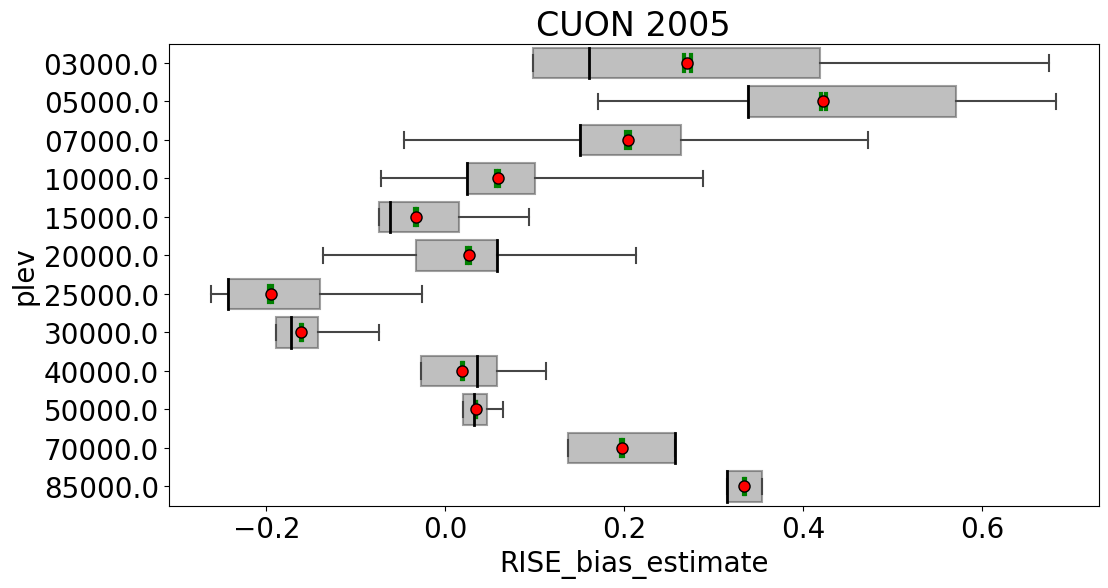

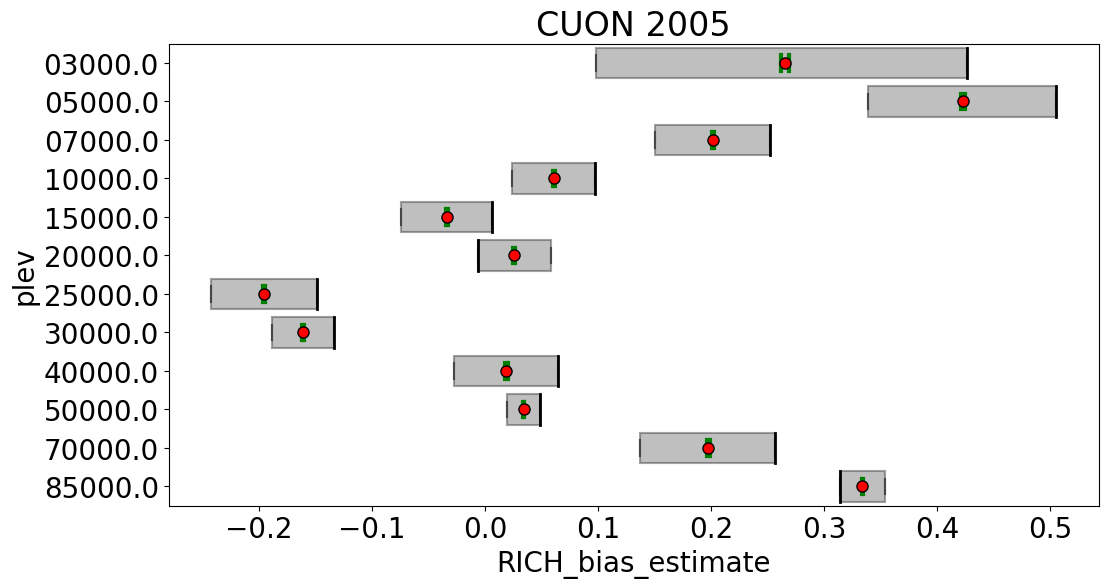

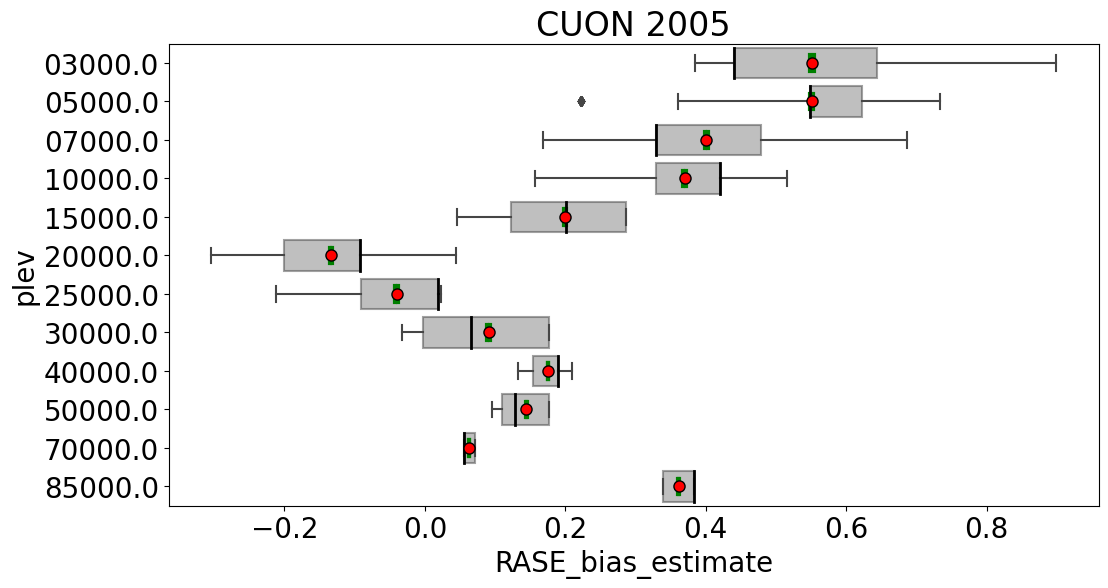

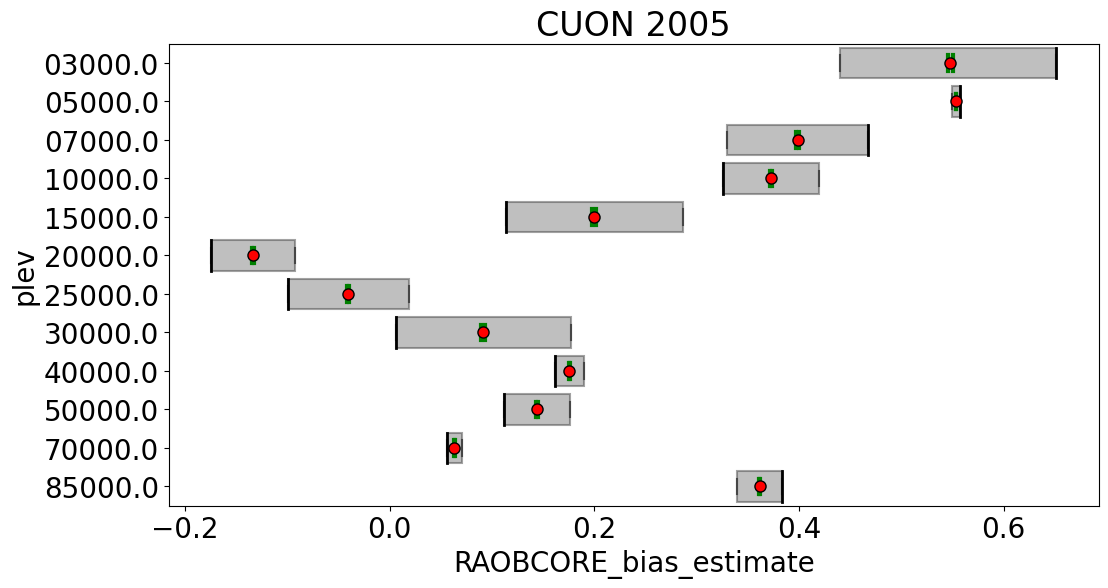

In [9]:
df_in.plev = df_in.plev.str.zfill(7)
df_in = df_in.sort_values(by='plev')

for i in ['RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate',]:
    q3, q1 = np.percentile(df_in[i].dropna(), [75 ,25])
    iqr = q3 - q1
    df_in[i] = df_in[i][np.logical_and(df_in[i] < 3*iqr, df_in[i] > -3*iqr)]

    ax = seaborn.boxplot(
        data=df_in, x=i, y="plev",
        notch=False, showcaps=True, showfliers=True, 
        dodge=False, showmeans=True, 
        boxprops={"facecolor": 'grey', "alpha":0.5},
        medianprops={"color": 'black', "linewidth" : 2},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        whis=3,
        # whis=1.5,
    )
    kwargs = {'alpha':0}
    ax = seaborn.barplot(data=df_in, x=i, y="plev", capsize=.4, n_boot=len(df_in[i]), errorbar=('sd',float(2/np.sqrt(len(df_in[i])))), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('CUON 2005')
    # ax = seaborn.barplot(data=df_in, x=i, y="plev", capsize=.2, n_boot=len(df_in[i]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
    plt.show()
    plt.close()



In [10]:
# rq = {
#     "statid": "11035",
    
#     "date": ["20050101-20051231"],
#     "variable": ["relative_humidity"],# "wind_speed", "geopotential"],
#     "format": "nc",
#     "optional": ['humidity_bias_estimate',],
#     # "dummy": str(np.random.rand()),
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
# df = dl.to_dataframe()

# df = df[df.plev == 30000]

# hist_data = []
# for i in ['humidity_bias_estimate']:# 'obs_minus_an','obs_minus_bg']:
#     hist_data.append(df[i].dropna())
#     ax = seaborn.histplot(hist_data[-1], label = i, kde=True, bins=70)
# ax.set(xlabel='Adjustments')
# plt.legend() 
# plt.show()

0.024004225115463206


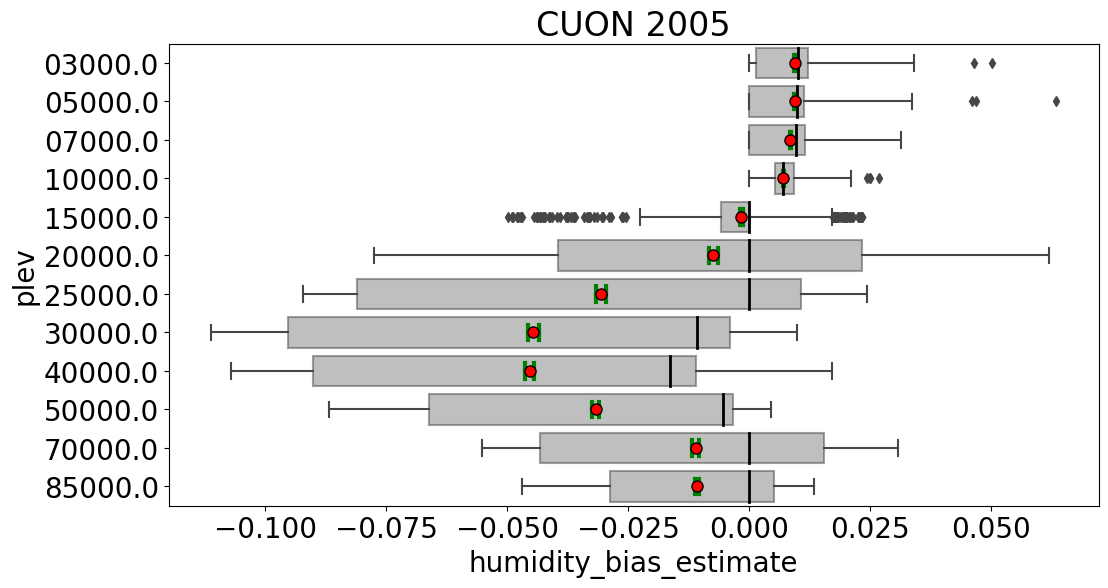

In [11]:
rq = {
    "statid": "11035",
    
    "date": ["20050101-20051231"],
    "variable": ["relative_humidity"],# "wind_speed", "geopotential"],
    "format": "nc",
    "optional": ['humidity_bias_estimate'],
    # "dummy": str(np.random.rand()),
}
df = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
df_all = df.to_dataframe()

df_in = df_all.copy()[df_all.plev.isin([3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000])]
df_in['plev'] = df_in['plev'].apply(str)

df_in.plev = df_in.plev.str.zfill(7)
df_in = df_in.sort_values(by='plev')

for i in zip(['humidity_bias_estimate',], ['grey']):
    ax = seaborn.boxplot(
        data=df_in, x=i[0], y="plev",
        notch=False, showcaps=True, showfliers=True, 
        dodge=False,
        boxprops={"facecolor": i[1], "alpha":0.5},
        medianprops={"color": 'black', "linewidth" : 2},
        whis=3,
        # whis=1.5,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
    )
    kwargs = {'alpha':0}
    factor = float(2/np.sqrt(len(df_in[i[0]])))
    print(factor)
    ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, n_boot=len(df_in[i[0]]), errorbar=('sd',factor), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('CUON 2005')
    # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)    
    plt.show()
    plt.close()

## Mauritius Data

In [12]:
with eua.CDMDataset(glob.glob("/users/staff/uvoggenberger/scratch/mauritius/*vais*.nc")[0]) as file:
    display(file)
    df_vais = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    df_vais = df_vais[df_vais.observed_variable == 126]
with eua.CDMDataset('/users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc') as file:
    display(file)
    df_meis = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    df_meis = df_meis[df_meis.observed_variable == 126]


File: <HDF5 file "0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc" (mode r)>
Filesize: 5.95 MB
Filename: /users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 52
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (56,)
 - V | recordtimestamp______________________________ : : (56,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units_____________________

File: <HDF5 file "0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc" (mode r)>
Filesize: 11.85 MB
Filename: /users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 53
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (250268,)
 - V | recordtimestamp______________________________ : : (250268,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units______________

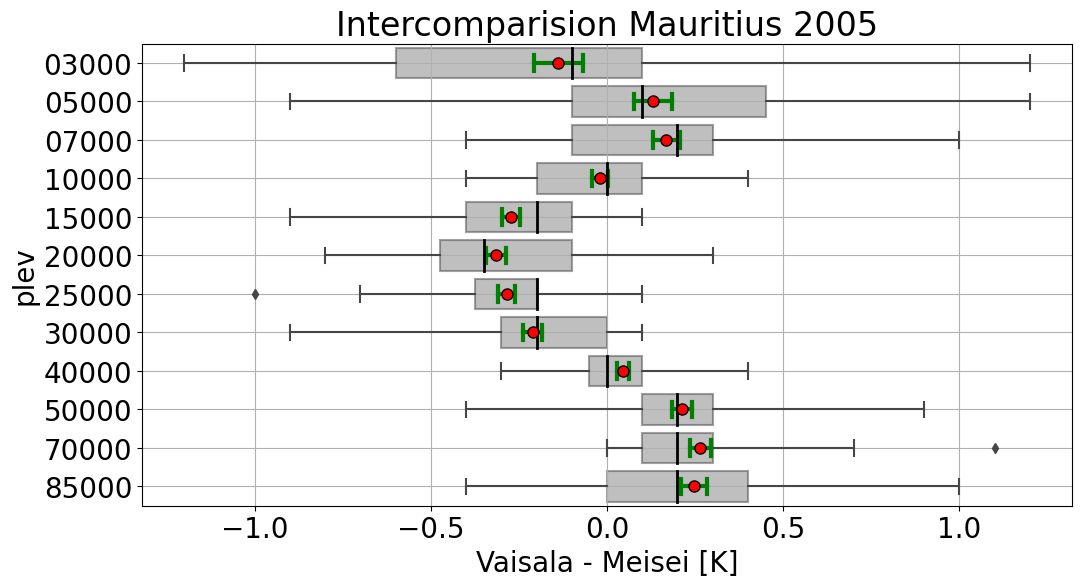

In [13]:
out = {'Difference':[], 'plev': []}
diffs = []
for i in df_vais.date_time.drop_duplicates():
    # print(i.date())
    meis_time = df_meis[df_meis.date_time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].date_time.iloc[0]
        dh = float((i-mt)/ np.timedelta64(1, 'h'))
        if np.logical_and( dh < -3, dh > -5):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_meis[df_meis.report_id == j]
            v_data = df_vais[df_vais.date_time == i]
            for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: #range(5000, 90000,5000):
                diffs.append(v_data[v_data.z_coordinate == find_nearest(v_data.z_coordinate, plev)].iloc[0].observation_value - m_data[m_data.z_coordinate == find_nearest(m_data.z_coordinate, plev)].iloc[0].observation_value)
                out['Difference'].append(diffs[-1])
                out['plev'].append(str(plev))

df_in = pd.DataFrame.from_dict(out)
df_in.plev = df_in.plev.str.zfill(5)
df_in = df_in.sort_values(by="plev")

for i in zip(
    [
        "Difference",
    ],
    ["grey"],
):
    q3, q1 = np.percentile(df_in[i[0]].dropna(), [75 ,25])
    iqr = q3 - q1
    df_in[i[0]] = df_in[i[0]][np.logical_and(df_in[i[0]] < 3*iqr, df_in[i[0]] > -3*iqr)]
    ax = seaborn.boxplot(
        data=df_in,
        x=i[0],
        y="plev",
        notch=False,
        showcaps=True,
        # fliersize = 100,
        showfliers=True,
        dodge=False,
        showmeans=True,
        boxprops={"facecolor": i[1], "alpha": 0.5},
        medianprops={"color": 'black', "linewidth": 2,},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        whis=3,
        # whis=1.5,
    )
    ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
    # ax.set_label(Vaisala - Meisei)
    kwargs = {'alpha':0}
    ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, n_boot=len(df_in[i[0]]), errorbar=('sd',float(2/np.sqrt(len(df_in[i[0]])))), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('Intercomparision Mauritius 2005')
    ax.set_xlabel('Vaisala - Meisei [K]')
    # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
    plt.grid()
    plt.show()
    plt.close()

## 47646 as Meisei and 47678 as Vaisala

0    J9H 
Name: sonde_type, dtype: object
0    VN8 
Name: sonde_type, dtype: object


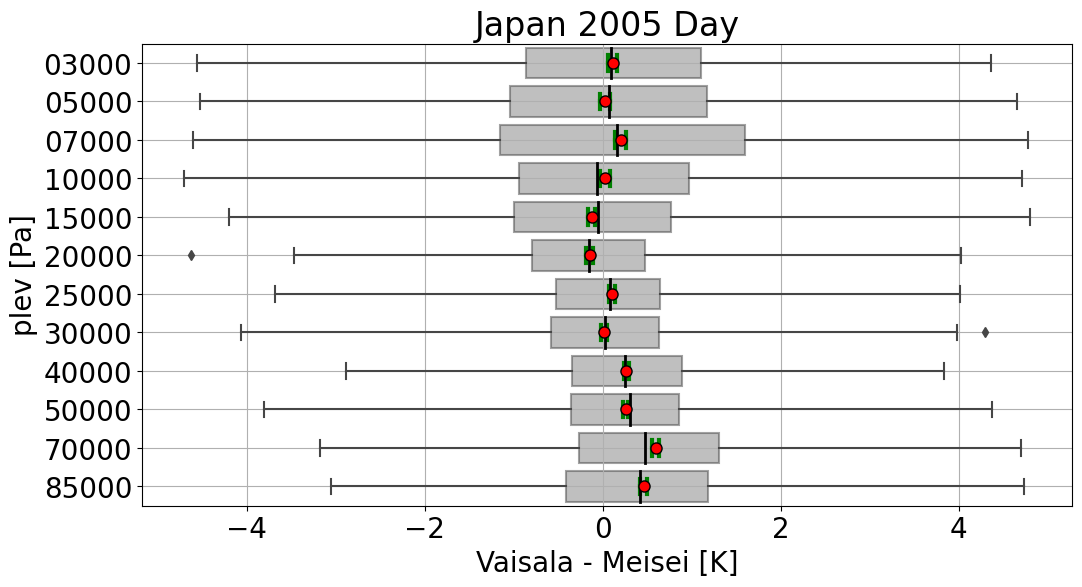

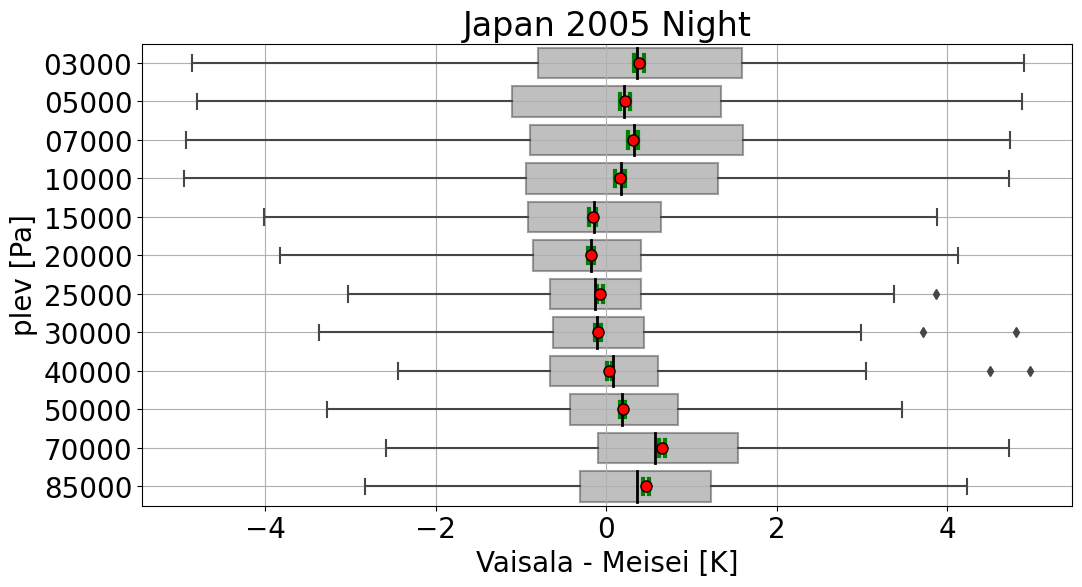

In [14]:
rq = {
    "statid": "47646",
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
df_tateno.obs_minus_bg = df_tateno.obs_minus_bg + df_tateno.bias_estimate
print(df_tateno.sonde_type.drop_duplicates())

rq = {
    "statid": "47678",
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl.to_dataframe()
df_compare.obs_minus_bg = df_compare.obs_minus_bg + df_compare.bias_estimate
print(df_compare.sonde_type.drop_duplicates())

out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    # print(i.date())
    meis_time = df_tateno[df_tateno.time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].time.iloc[0]
        dh = float((i - mt) / np.timedelta64(1, "h"))
        if np.logical_and(dh < 1, dh > -1):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_tateno[df_tateno.report_id == j]
            v_data = df_compare[df_compare.time == i]
            for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: #range(5000, 90000, 5000):
                diffs.append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                    - m_data[m_data.plev == find_nearest(m_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                )
                out["time"].append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
                )
                out["Difference"].append(diffs[-1])
                out["plev"].append(str(plev))

for tm in ["Day", "Night"]:
    df_in = pd.DataFrame.from_dict(out)
    if tm == "Day":
        df_in = df_in[np.logical_or(df_in.time.dt.hour > 21, df_in.time.dt.hour <= 9)]
    else:
        df_in = df_in[np.logical_and(df_in.time.dt.hour <= 21, df_in.time.dt.hour > 9)]
    df_in.plev = df_in.plev.str.zfill(5)
    df_in = df_in.sort_values(by="plev")

    for i in zip(
        [
            "Difference",
        ],
        ["grey"],
    ):
        q3, q1 = np.percentile(df_in[i[0]].dropna(), [75, 25])
        iqr = q3 - q1
        df_in[i[0]] = df_in[i[0]][
            np.logical_and(df_in[i[0]] < 3 * iqr, df_in[i[0]] > -3 * iqr)
        ]
        ax = seaborn.boxplot(
            data=df_in,
            x=i[0],
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=True,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": i[1], "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
        kwargs = {'alpha':0}
        ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, n_boot=len(df_in[i[0]]), errorbar=('sd',float(2/np.sqrt(len(df_in[i[0]])))), errwidth=3, errcolor='green', **kwargs)
        # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
        ax.set_title('Japan 2005 '+ tm)
        ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
        plt.grid()
        plt.show()
        plt.close()

In [15]:
# rq = {
#     "country": "JPN",
#     "date": ["20100101-20101231"],
#     "variable": ["air_temperature"],
#     "format": "nc",
#     "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)

In [16]:
# for i in dl:
#     display(dl[i].to_dataframe())

In [17]:
# rq = {
#     "statid": "47991",
#     "date": ["20050101-20101231"],
#     "variable": ["air_temperature"],
#     "format": "nc",
#     "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)
# df = dl.to_dataframe()
# df.obs_minus_bg = df.obs_minus_bg + df.bias_estimate
# df

0    J01 
Name: sonde_type, dtype: object


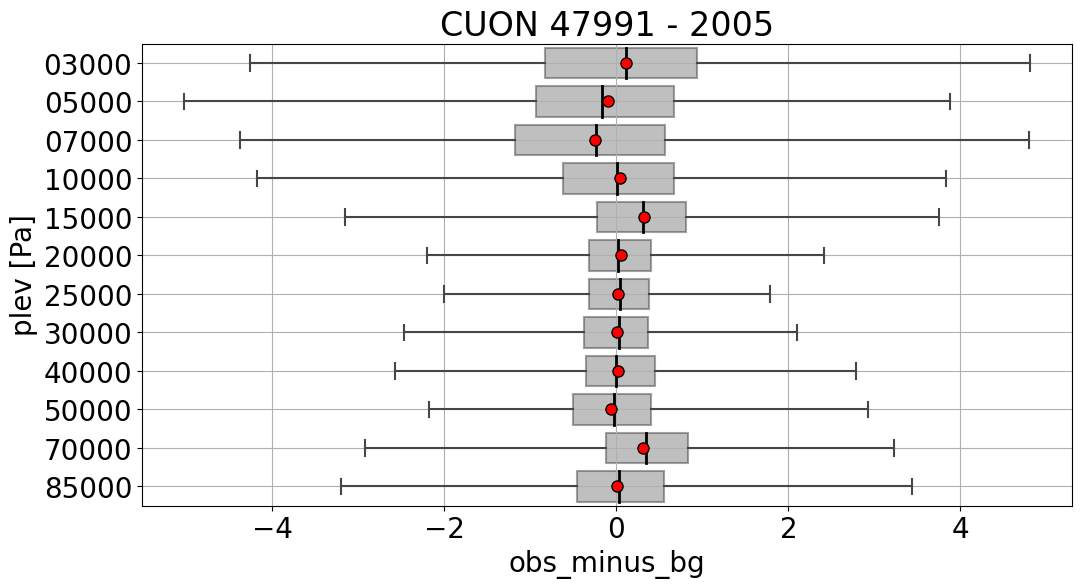

0    J01 
Name: sonde_type, dtype: object


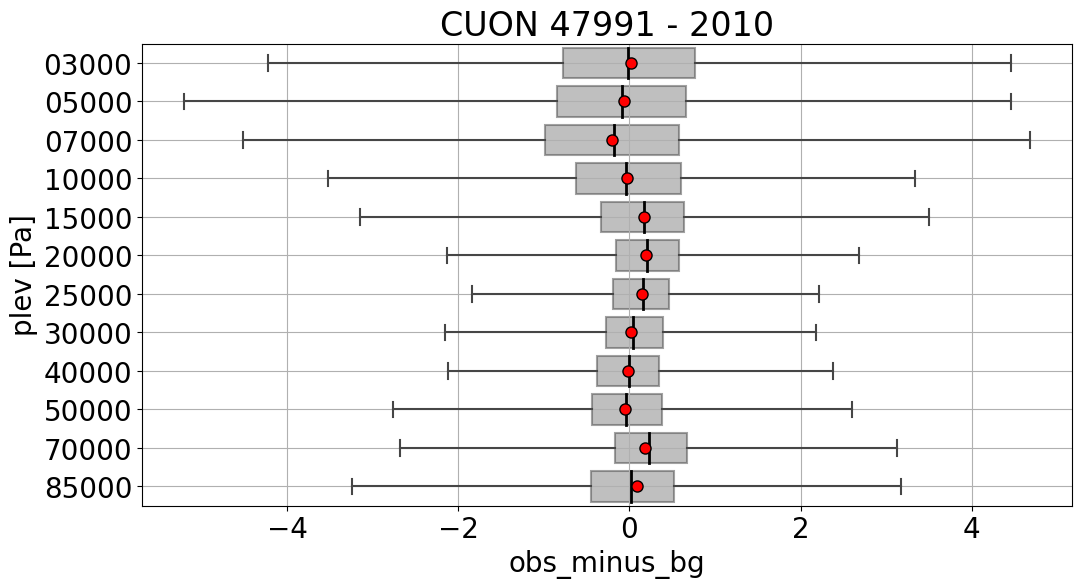

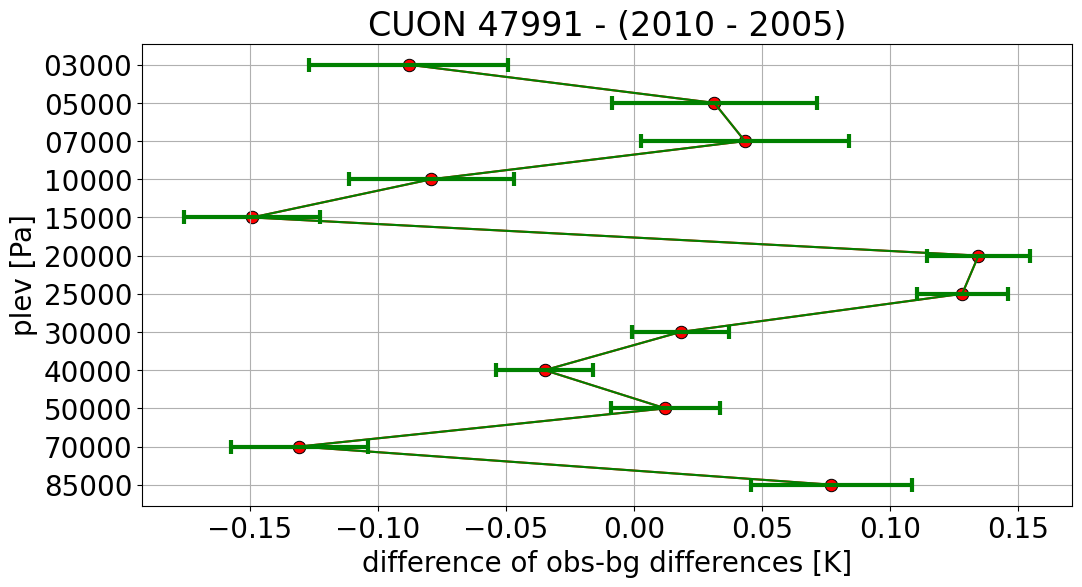

In [18]:
rq = {
    "statid": "47991",
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = copy.deepcopy(dl.to_dataframe())
df_tateno.obs_minus_bg = df_tateno.obs_minus_bg + df_tateno.bias_estimate
print(df_tateno.sonde_type.drop_duplicates())


out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_tateno.time.drop_duplicates():
    v_data = df_tateno[df_tateno.time == i]
    for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: # range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2008 = pd.DataFrame.from_dict(out)
df_in_2008.plev = df_in_2008.plev.str.zfill(5)

ax = seaborn.boxplot(
            data=df_in_2008,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47991 - 2005')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

try:
    del dl
    del v_data
    del df_in
except:
    pass

rq = {
    "statid": "47991",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = copy.deepcopy(dl.to_dataframe())
df_compare.obs_minus_bg = df_compare.obs_minus_bg + df_compare.bias_estimate
print(df_compare.sonde_type.drop_duplicates())
out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    v_data = df_compare[df_compare.time == i]
    for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: #range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2010 = pd.DataFrame.from_dict(out)
df_in_2010.plev = df_in_2010.plev.str.zfill(5)


ax = seaborn.boxplot(
            data=df_in_2010,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47991 - 2010')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

year_diff = df_in_2010.groupby('plev').mean() - df_in_2008.groupby('plev').mean()
year_diff = year_diff.sort_values('plev')
ax = seaborn.scatterplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            marker= "o",
            color = "red",
            edgecolor= 'black',
            s = 80,
        )
ax = seaborn.lineplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            color = "red",
            sort=False,
        )
ax.set_title('CUON 47991 - (2010 - 2005)')
ax.set(xlabel="difference of obs-bg differences [K]", ylabel="plev [Pa]")
ci_2008 = df_in_2008.groupby('plev').std().Difference * float(1.96/np.sqrt(len(df_in_2008['Difference'])))
ci_2010 = df_in_2010.groupby('plev').std().Difference * float(1.96/np.sqrt(len(df_in_2010['Difference'])))
ci_diff = np.sqrt(ci_2010**2 + ci_2008**2)
(_, caps0, _) = plt.errorbar(x=year_diff['Difference'], y = year_diff.index, xerr=np.array(ci_diff).flatten(), color='green', label='combined uncertainty', capsize=5, elinewidth=3, )#linestyle='', )
for cap in caps0:
    cap.set_markeredgewidth(3)

plt.grid()
plt.show()
plt.close()

0    J9H 
Name: sonde_type, dtype: object


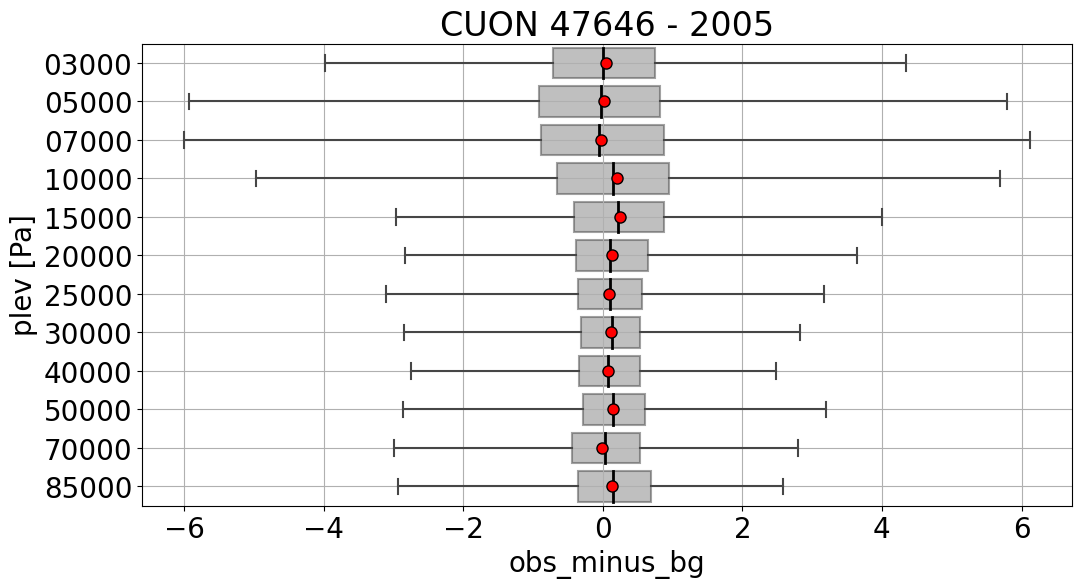

0    J9H 
Name: sonde_type, dtype: object


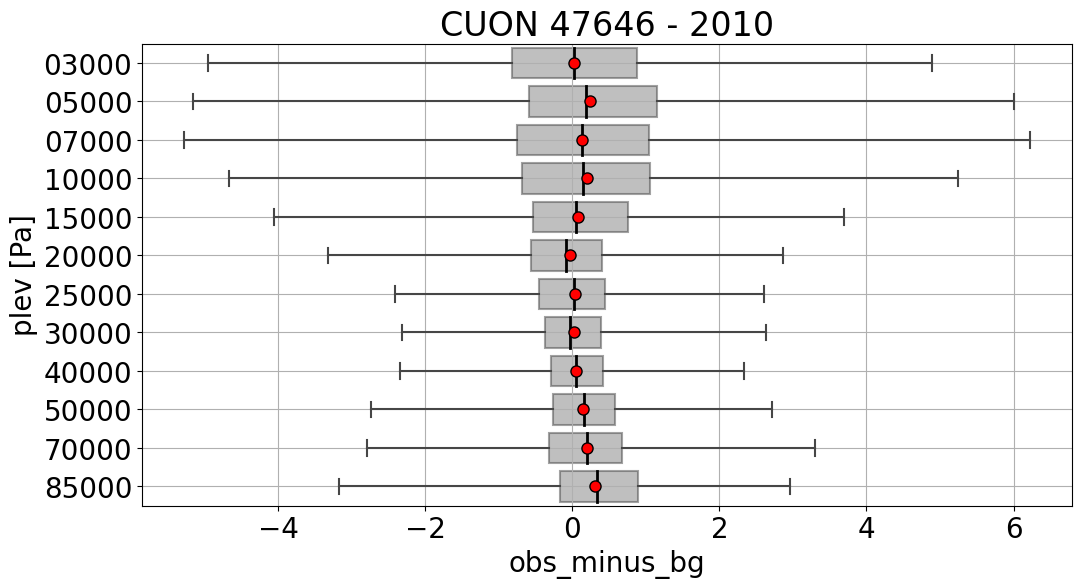

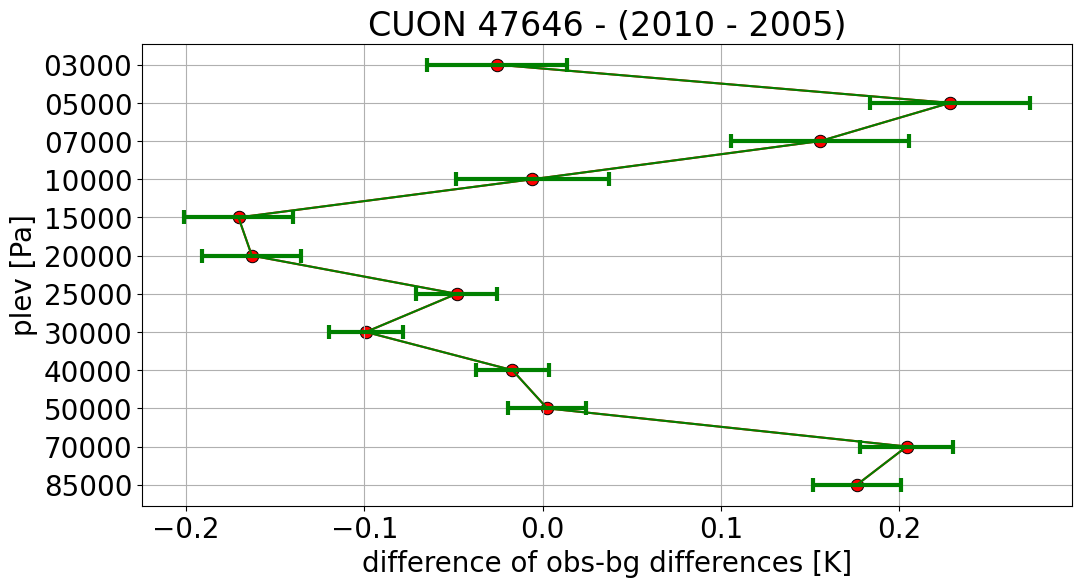

In [19]:
%reset -f

import sys
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20, 'display.max_columns', 50)
import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import re
import copy


sys.path.append(os.getcwd() + "/../../cds-backend/code/")
import cds_eua4 as eua

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (12, 6)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

rq = {
    "statid": "47646",
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = copy.deepcopy(dl.to_dataframe())
df_tateno.obs_minus_bg = df_tateno.obs_minus_bg + df_tateno.bias_estimate
print(df_tateno.sonde_type.drop_duplicates())


out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_tateno.time.drop_duplicates():
    v_data = df_tateno[df_tateno.time == i]
    for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: # range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2008 = pd.DataFrame.from_dict(out)
df_in_2008.plev = df_in_2008.plev.str.zfill(5)

ax = seaborn.boxplot(
            data=df_in_2008,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47646 - 2005')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

try:
    del dl
    del v_data
    del df_in
except:
    pass

rq = {
    "statid": "47646",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = copy.deepcopy(dl.to_dataframe())
df_compare.obs_minus_bg = df_compare.obs_minus_bg + df_compare.bias_estimate
print(df_compare.sonde_type.drop_duplicates())
out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    v_data = df_compare[df_compare.time == i]
    for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: #range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2010 = pd.DataFrame.from_dict(out)
df_in_2010.plev = df_in_2010.plev.str.zfill(5)


ax = seaborn.boxplot(
            data=df_in_2010,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47646 - 2010')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

year_diff = df_in_2010.groupby('plev').mean() - df_in_2008.groupby('plev').mean()
year_diff = year_diff.sort_values('plev')
ax = seaborn.scatterplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            marker= "o",
            color = "red",
            edgecolor= 'black',
            s = 80,
        )
ax = seaborn.lineplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            color = "red",
            sort=False,
        )
ax.set_title('CUON 47646 - (2010 - 2005)')
ax.set(xlabel="difference of obs-bg differences [K]", ylabel="plev [Pa]")
ci_2008 = df_in_2008.groupby('plev').std().Difference * float(1.96/np.sqrt(len(df_in_2008['Difference'])))
ci_2010 = df_in_2010.groupby('plev').std().Difference * float(1.96/np.sqrt(len(df_in_2010['Difference'])))
ci_diff = np.sqrt(ci_2010**2 + ci_2008**2)
(_, caps0, _) = plt.errorbar(x=year_diff['Difference'], y = year_diff.index, xerr=np.array(ci_diff).flatten(), color='green', label='combined uncertainty', capsize=5, elinewidth=3, )#linestyle='', )
for cap in caps0:
    cap.set_markeredgewidth(3)

plt.grid()
plt.show()
plt.close()

0    J9H 
Name: sonde_type, dtype: object


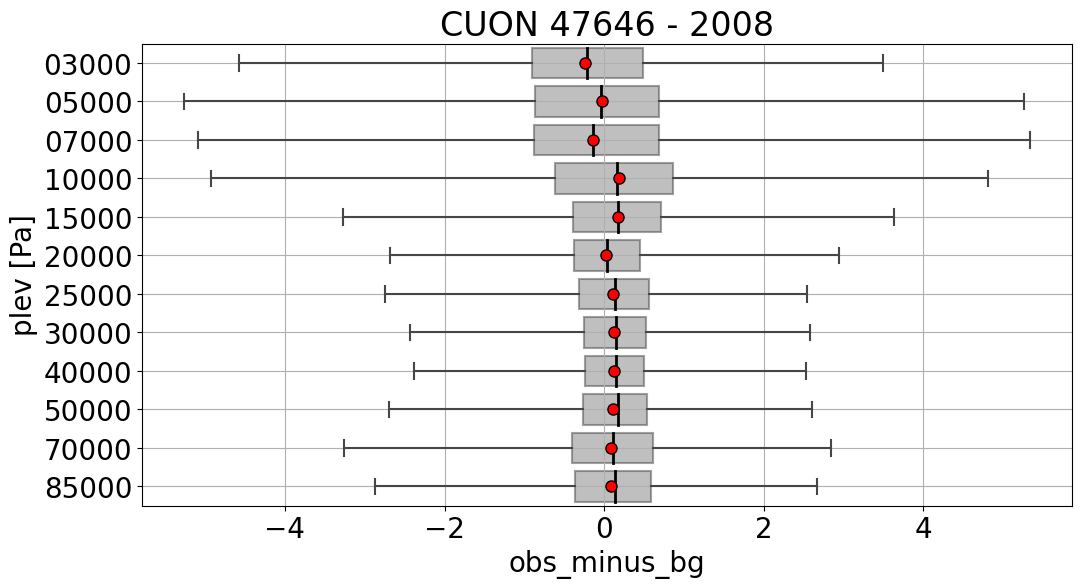

0    J9H 
Name: sonde_type, dtype: object


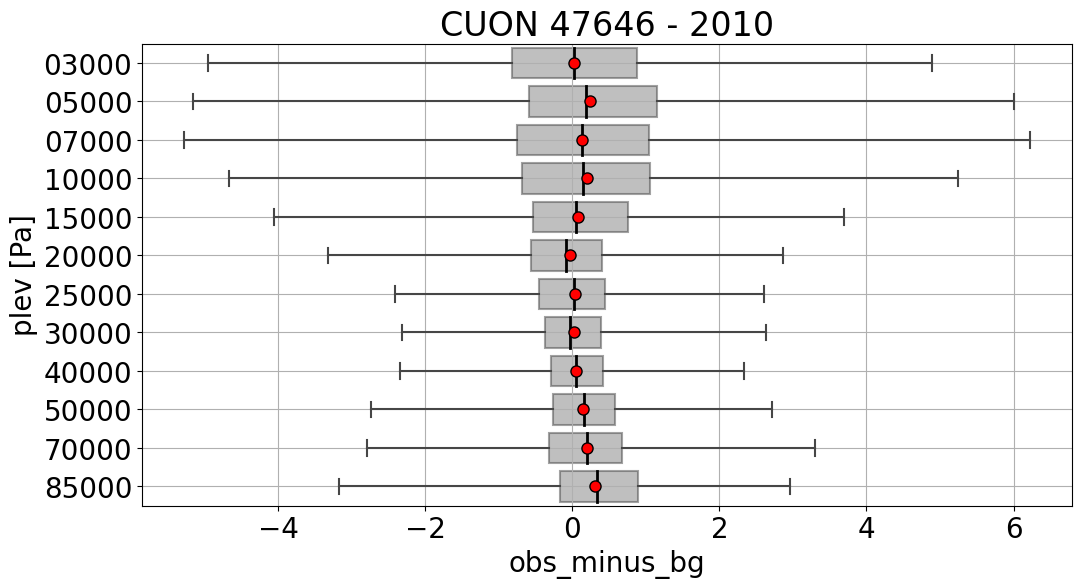

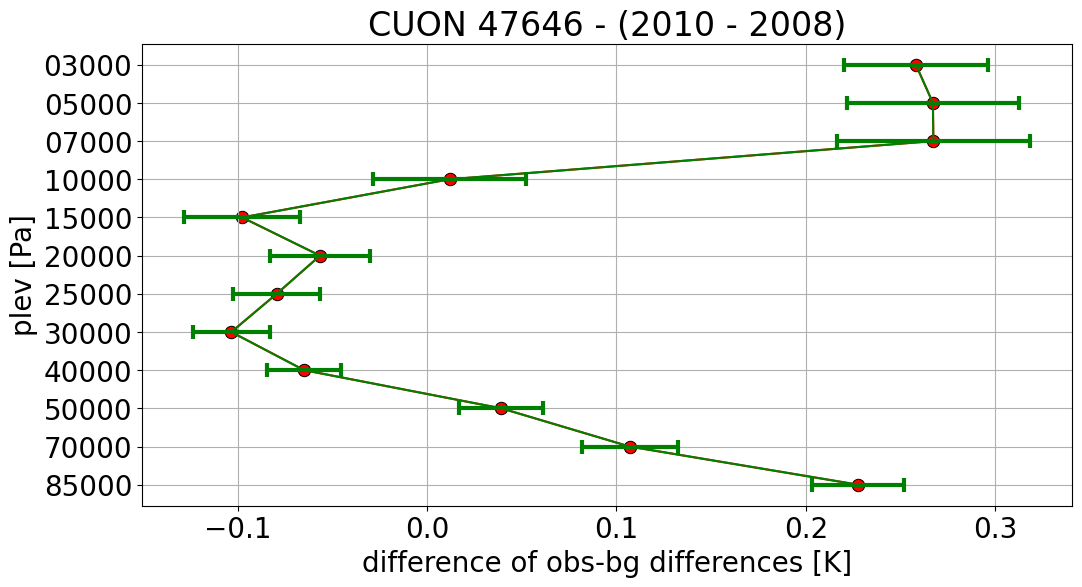

In [20]:
%reset -f

import sys
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20, 'display.max_columns', 50)
import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import re
import copy


sys.path.append(os.getcwd() + "/../../cds-backend/code/")
import cds_eua4 as eua

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (12, 6)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


rq = {
    "statid": "47646",
    "date": ["20080101-20081231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = copy.deepcopy(dl.to_dataframe())
df_tateno.obs_minus_bg = df_tateno.obs_minus_bg + df_tateno.bias_estimate
print(df_tateno.sonde_type.drop_duplicates())


out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_tateno.time.drop_duplicates():
    v_data = df_tateno[df_tateno.time == i]
    for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: #range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2008 = pd.DataFrame.from_dict(out)
df_in_2008.plev = df_in_2008.plev.str.zfill(5)

ax = seaborn.boxplot(
            data=df_in_2008,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47646 - 2008')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

try:
    del dl
    del v_data
    del df_in
except:
    pass

rq = {
    "statid": "47646",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = copy.deepcopy(dl.to_dataframe())
df_compare.obs_minus_bg = df_compare.obs_minus_bg + df_compare.bias_estimate
print(df_compare.sonde_type.drop_duplicates())
out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    v_data = df_compare[df_compare.time == i]
    for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: #range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2010 = pd.DataFrame.from_dict(out)
df_in_2010.plev = df_in_2010.plev.str.zfill(5)


ax = seaborn.boxplot(
            data=df_in_2010,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47646 - 2010')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

year_diff = df_in_2010.groupby('plev').mean() - df_in_2008.groupby('plev').mean()
year_diff = year_diff.sort_values('plev')
ax = seaborn.scatterplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            marker= "o",
            color = "red",
            edgecolor= 'black',
            s = 80,
        )
ax = seaborn.lineplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            color = "red",
            sort=False,
        )
ci_2008 = df_in_2008.groupby('plev').std().Difference * float(1.96/np.sqrt(len(df_in_2008['Difference'])))
ci_2010 = df_in_2010.groupby('plev').std().Difference * float(1.96/np.sqrt(len(df_in_2010['Difference'])))
ci_diff = np.sqrt(ci_2010**2 + ci_2008**2)
(_, caps0, _) = plt.errorbar(x=year_diff['Difference'], y = year_diff.index, xerr=np.array(ci_diff).flatten(), color='green', label='combined uncertainty', capsize=5, elinewidth=3, )#linestyle='', )
for cap in caps0:
    cap.set_markeredgewidth(3)
ax.set_title('CUON 47646 - (2010 - 2008)')
ax.set(xlabel="difference of obs-bg differences [K]", ylabel="plev [Pa]")

plt.grid()
plt.show()
plt.close()

In [23]:
# rq = {
#     "statid": "47646",
#     "date": ["20050101-20051231"],
#     "variable": ["air_temperature"],
#     "format": "nc",
#     "optional": ["sonde_type", "obs_minus_bg"],
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)
# df_tateno = dl.to_dataframe()
# print(df_tateno.sonde_type.drop_duplicates())

# rq = {
#     "statid": "47678",
#     "date": ["20050101-20051231"],
#     "variable": ["air_temperature"],
#     "format": "nc",
#     "optional": ["sonde_type", "obs_minus_bg"],
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)
# df_compare = dl.to_dataframe()
# print(df_compare.sonde_type.drop_duplicates())

# out = {"Difference": [], "plev": [], "time": []}
# diffs = []
# for i in df_compare.time.drop_duplicates():
#     # print(i.date())
#     meis_time = df_tateno[df_tateno.time.dt.date == i.date()]
#     for j in meis_time.report_id.drop_duplicates():
#         mt = meis_time[meis_time.report_id == j].time.iloc[0]
#         dh = float((i - mt) / np.timedelta64(1, "h"))
#         if np.logical_and(dh < 1, dh > -1):
#             # print(i, mt, "delta hours: ", dh)
#             # print(j)
#             # print()
#             m_data = df_tateno[df_tateno.report_id == j]
#             v_data = df_compare[df_compare.time == i]
#             for plev in range(5000, 90000, 5000):
#                 diffs.append(
#                     v_data[v_data.plev == find_nearest(v_data.plev, plev)]
#                     .iloc[0]
#                     .obs_minus_bg
#                     - m_data[m_data.plev == find_nearest(m_data.plev, plev)]
#                     .iloc[0]
#                     .obs_minus_bg
#                 )
#                 out["time"].append(
#                     v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
#                 )
#                 out["Difference"].append(diffs[-1])
#                 out["plev"].append(str(plev))

# df_in = pd.DataFrame.from_dict(out)
# to_df = {'plev':[], 'time':[], 'Difference':[]}

# for i in df_in[df_in.time.dt.hour == 0].time:
#     for j in df_in[df_in.time.dt.date == i.date()].plev.drop_duplicates():
#         try:
#             sel_df = (df_in[np.logical_and(df_in.time.dt.date == i.date(), df_in.plev == j)])
#             diff = sel_df[sel_df.time.dt.hour == 0].Difference.values - sel_df[sel_df.time.dt.hour == 12].Difference.values
#             to_df['Difference'].append(diff[0])
#             to_df['plev'].append(j)
#             to_df['time'].append(i)
#         except:
#             pass
# df_in = pd.DataFrame.from_dict(to_df)

# df_in.plev = df_in.plev.str.zfill(5)
# df_in = df_in.sort_values(by="plev")

# for i in zip(
#     [
#         "Difference",
#     ],
#     ["grey"],
# ):
#     q3, q1 = np.percentile(df_in[i[0]].dropna(), [75, 25])
#     iqr = q3 - q1
#     df_in[i[0]] = df_in[i[0]][
#         np.logical_and(df_in[i[0]] < 3 * iqr, df_in[i[0]] > -3 * iqr)
#     ]
#     ax = seaborn.boxplot(
#         data=df_in,
#         x=i[0],
#         y="plev",
#         notch=False,
#         showcaps=True,
#         # fliersize = 100,
#         showfliers=True,
#         dodge=False,
#         showmeans=True,
#         boxprops={"facecolor": i[1], "alpha": 0.5},
#         medianprops={
#             "color": i[1],
#             "linewidth": 2,
#         },
#         meanprops={
#             "marker": "o",
#             "markerfacecolor": "red",
#             "markeredgecolor": "black",
#             "markersize": "8",
#         },
#         whis=3,
#         # whis=1.5,
#     )
#     ax.set_title('Japan 2005 '+ 'Night - Day')
#     ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
#     plt.grid()
#     plt.show()
#     plt.close()

In [24]:
# ax = seaborn.histplot(df_diff, label='Vaisala - Meisei', kde=True)
# ax.set(xlabel="Adjustments")
# ax.set(title='temperature difference to Vaisala sonde')
# plt.legend()
# plt.show()

## 2010 intercomparison 

In [25]:
table = pd.read_csv('./table3685.csv')
interc = pd.read_csv('./wmo_intercomparison_2010.csv')

In [26]:
for i in interc.sonde_id.drop_duplicates():
    print(table[table.tac_code == i].description)

Series([], Name: description, dtype: object)
Series([], Name: description, dtype: object)
40    Graw DFM-06 (Germany)
Name: description, dtype: object
Series([], Name: description, dtype: object)
Series([], Name: description, dtype: object)
27                              Sprenger E085 (Germany)
79    Vaisala RS41 with pressure derived from GPS he...
Name: description, dtype: object
29    AIR IS - 4A - 1680 (United States)
81        NanJing Daqiao XGP-3G (China)*
Name: description, dtype: object
85    Meisei RS2-91 (Japan)
Name: description, dtype: object
Series([], Name: description, dtype: object)
56    Vaisala RS80 /Autosonde (Finland)
Name: description, dtype: object
60    Sippican MARK II with chip thermistor, carbon ...
Name: description, dtype: object
11              Mesural FMO 1950A (France)
45    Vaisala RS41/DigiCORA MW41 (Finland)
Name: description, dtype: object
12          Mesural FMO 1945A (France)
46    Vaisala RS41/AUTOSONDE (Finland)
Name: description, dtype: object
2

In [27]:
len(interc.sonde_code.drop_duplicates()), len(interc.sonde_id.drop_duplicates()), len(interc.sonde_name.drop_duplicates())

(13, 15, 10)

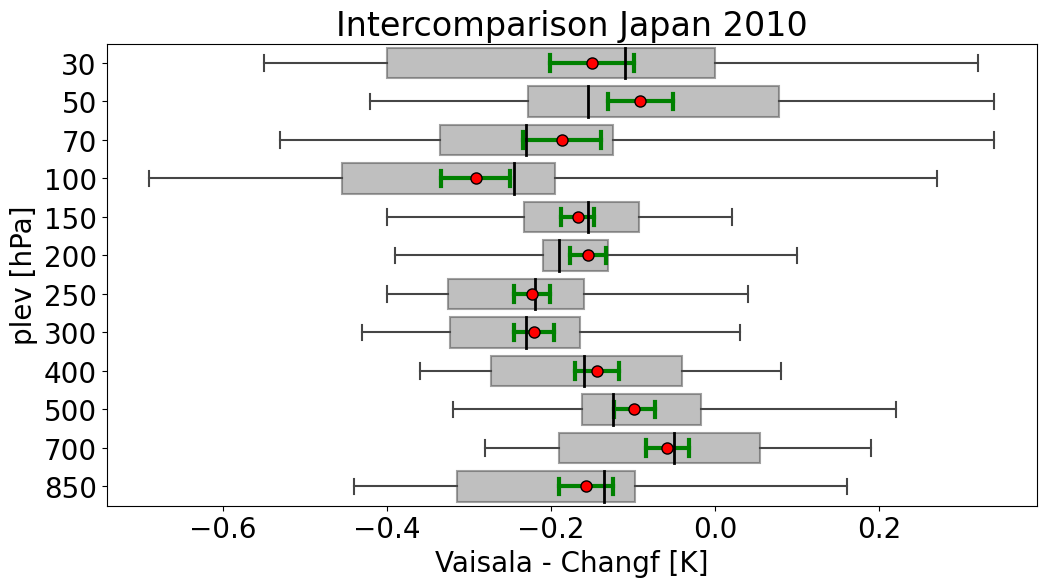

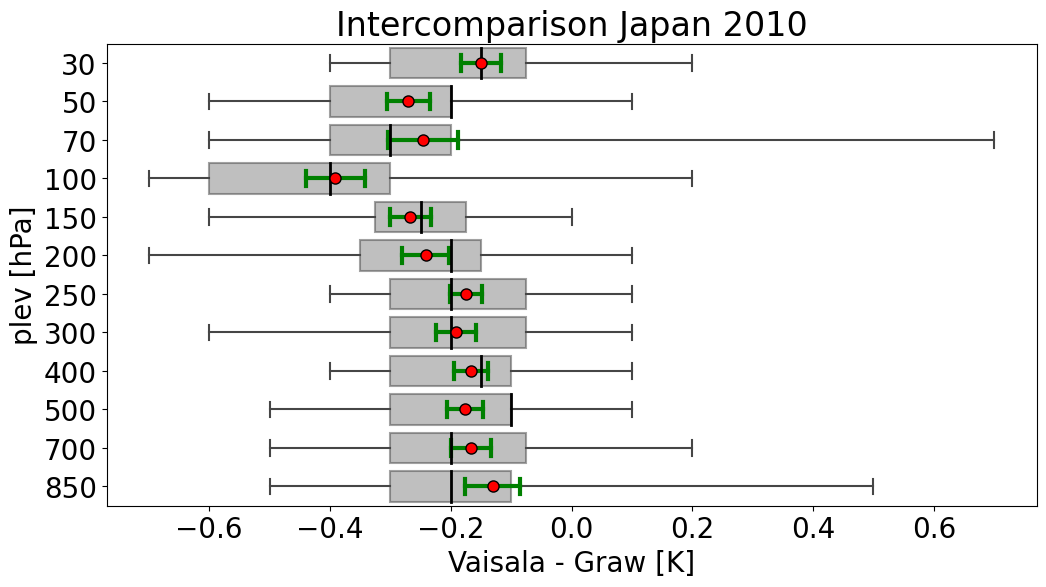

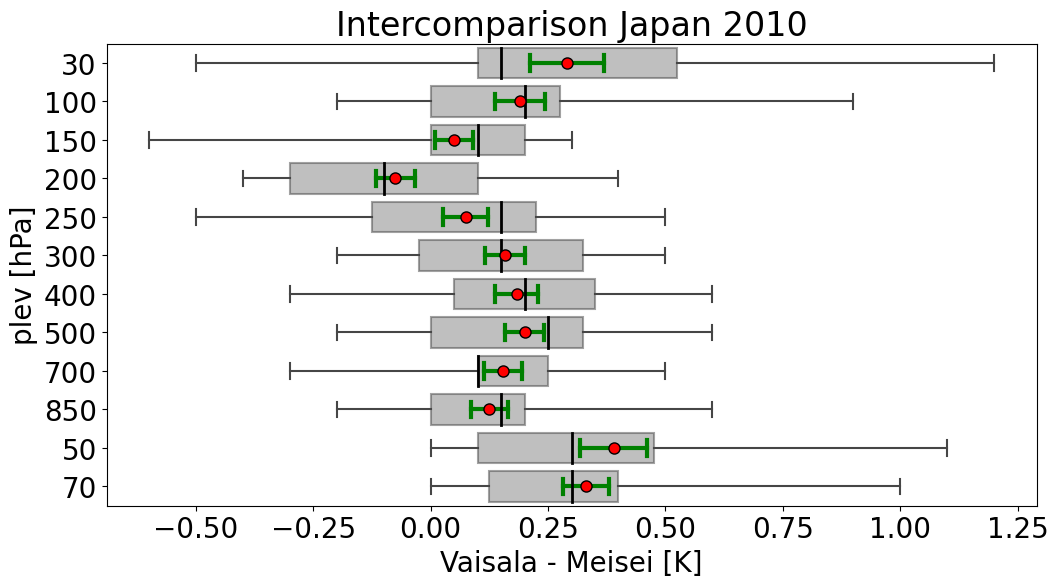

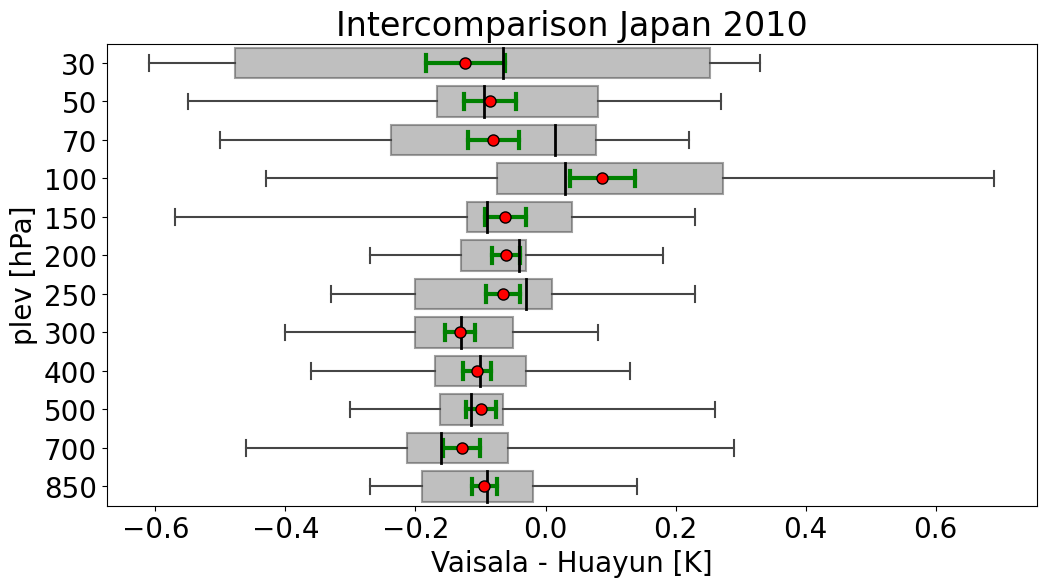

In [13]:
data_cleaned = {}
plevs = {}


for asc in np.sort(glob.glob('/users/staff/uvoggenberger/CEUAS/CEUAS/public/intercomparisons/DATA/Vaisala/*')):
    try:
        ascentnr = asc[-3:]
        for i in glob.glob('/users/staff/uvoggenberger/CEUAS/CEUAS/public/intercomparisons/DATA/*/*.'+ascentnr):
            text = open(i, "r", encoding= 'unicode_escape')
            # display(text)

            #join() method combines all contents of 
            # csvfile.csv and formed as a string
            text = ''.join([j for j in text]) 

            # search and replace the contents
            text = text.replace("\t", ",") 
            text = re.sub(" +", ",", text)
            # output.csv is the output file opened in write mode
            x = open('./'+i.split('/')[-1],"w")

            # all the replaced text is written in the output.csv file
            x.writelines(text)
            x.close()

        yang_dfs = []
        for i in glob.glob('./*.'+ascentnr):
            df = pd.read_csv(i, delimiter=',', header=0, encoding= 'unicode_escape')
            # print(i)
            yang_dfs.append(df)

        labels = glob.glob('./*.'+ascentnr)
        compare_to = labels.index([s for s in labels if "Vaisala" in s][0])
        # print(compare_to)

        yang_dfs[compare_to].Pressure = pd.to_numeric(yang_dfs[compare_to].Pressure, errors='coerce')
        yang_dfs[compare_to] = yang_dfs[compare_to].dropna(subset = ['Pressure'])
        yang_dfs[compare_to].Temperature = pd.to_numeric(yang_dfs[compare_to].Temperature, errors='coerce')
        yang_dfs[compare_to] = yang_dfs[compare_to].dropna(subset = ['Temperature'])
        
        for plev_to_check in [30,50,70,100,150,200,250,300,400,500,700,850]: #range(50, 900, 50):
            cp_to = yang_dfs[compare_to][yang_dfs[compare_to].Pressure == find_nearest(yang_dfs[compare_to].Pressure, plev_to_check)]

            for sonde in range(len(labels)):
                label = labels[sonde][2:].split('.')[0]
                if sonde == compare_to:
                    continue

                yang_dfs[sonde].Pressure = pd.to_numeric(yang_dfs[sonde].Pressure, errors='coerce')
                yang_dfs[sonde] = yang_dfs[sonde].dropna(subset = ['Pressure'])
                yang_dfs[sonde].Temperature = pd.to_numeric(yang_dfs[sonde].Temperature, errors='coerce')
                yang_dfs[sonde] = yang_dfs[sonde].dropna(subset = ['Temperature'])

                for press in range(len(cp_to)):
                    delta_t = (
                        cp_to.Temperature.iloc[press]
                        - yang_dfs[sonde][
                            yang_dfs[sonde].Pressure
                            == find_nearest(
                                np.array(yang_dfs[sonde].Pressure),
                                cp_to.Pressure.iloc[press]
                            )
                        ].Temperature.values[0]
                    )
                if label in list(data_cleaned.keys()):
                    data_cleaned[label].append(delta_t)
                    plevs[label].append(str(plev_to_check))
                else:
                    data_cleaned[label]=[delta_t]
                    plevs[label]=[str(plev_to_check)]

    except:
        pass
        # print('error')
        
try: 
    labels.remove('./Vaisala.069')
except: 
    pass

for i in labels:
    label = i[2:].split(".")[0]
    data_cleaned[label] = np.array(data_cleaned[label])
    plevs[label] = np.array(plevs[label])
    q3, q1 = np.percentile(data_cleaned[label], [75 ,25])
    iqr = q3 - q1
    plevs[label] = plevs[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]
    data_cleaned[label] = data_cleaned[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]
    

    ax = seaborn.boxplot(
        x=data_cleaned[label],
        y=plevs[label],
        notch=False,
        showcaps=True,
        showfliers=True,
        dodge=False,
        boxprops={"facecolor": "grey", "alpha": 0.5},
        medianprops={"color": "black", "linewidth": 2},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        showmeans =  True, 
        whis=np.inf,
        # whis=1.5,
    ).set(xlabel='Vaisala - ' + label + ' [K]', ylabel="plev [hPa]")
    kwargs = {'alpha':0}
    ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.4, n_boot=len(data_cleaned[label]), errorbar=('sd',float(2/np.sqrt(len(data_cleaned[label])))), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('Intercomparison Japan 2010')
    # ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
    # ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('pi',90), errwidth=3, **kwargs)

    plt.show()
    plt.close()

# Japan stations

JAM00047600  37.3914  136.8953    5.2 WAJIMA
JAM00047604  37.9170  139.0500    6.0 NIIGATA
JAM00047624  36.4000  139.0670  113.0 MAEBASHI
JAM00047646  36.0581  140.1258   25.2 TATENO
JAM00047655  34.6000  138.2170   47.0 OMAEZAKI
JAM00047678  33.1217  139.7792  151.2 HACHIJOJIMA
JAM00047681  34.7503  137.7030   45.7    HAMAMATSU AB
JAM00047684  34.9330  136.5830   56.0 YOKKAICHI
JAM00047688  34.9830  139.8330    6.0    TATEYAMA AB
JAM00047696  35.2800  139.6700   49.0 YOKOSUKA

In [14]:
coords = [[37.3914, 136.8953, 47600], [37.9170, 139.0500, 47604], [36.4000, 139.0670, 47624], [36.0581, 140.1258, 47646], [34.6000, 138.2170, 47655], 
          [33.1217, 139.7792, 47678], [34.7503, 137.7030, 47681], [34.9330, 136.5830, 47684], [34.9830, 139.8330, 47688], [35.2800, 139.6700, 47696]]

In [15]:
dist = []
target = [33.1217, 139.7792]
for i in coords:
    dist.append((i[2],np.abs(target[0] - i[0]) + np.abs(target[1] - i[1])))
dist

[(47600, 7.1536000000000115),
 (47604, 5.524499999999996),
 (47624, 3.9904999999999973),
 (47646, 3.2830000000000013),
 (47655, 3.0404999999999944),
 (47678, 0.0),
 (47681, 3.704800000000006),
 (47684, 5.007500000000007),
 (47688, 1.9150999999999954),
 (47696, 2.2675000000000196)]

In [16]:
for i in coords:
    if i[2] != 47646:
        try:
            rq = {
                "statid": str(i[2]),

                "date": ["20100101-20101231"],
                "variable": ["air_temperature"],
                "format": "nc",
                "optional": ['sonde_type', 'obs_minus_bg'],
            }
            dl = eua.vm_request_wrapper(rq, overwrite=True)
            df_compare = dl.to_dataframe()
            print(i[2])
            # display(df_compare)
        except:
            print(i[2], 'no data')

47600
47604 no data
47624 no data
47655 no data
47678
47681
47684 no data
47688 no data
47696 no data


##  568 :   J9H  :  J9H Japan Meisei RSII-91 radiosonde, RH correction {200302} 31313=74702^ (W3=47) <F=T1680FL,P=Ac,T=TR,U=A>


 ## 2639 :   VN8  :  VN8 Vaisala RS92 Autosonde auto corr, GPS wind 31313=48108^ <F=T400-406DL,P=Sc,T=Wc,U=2Ah,N=G>


## 310 km distance HACHIJOJIMA Island to TATENO 
## 2010

0    J9H 
Name: sonde_type, dtype: object
0    VN8 
Name: sonde_type, dtype: object


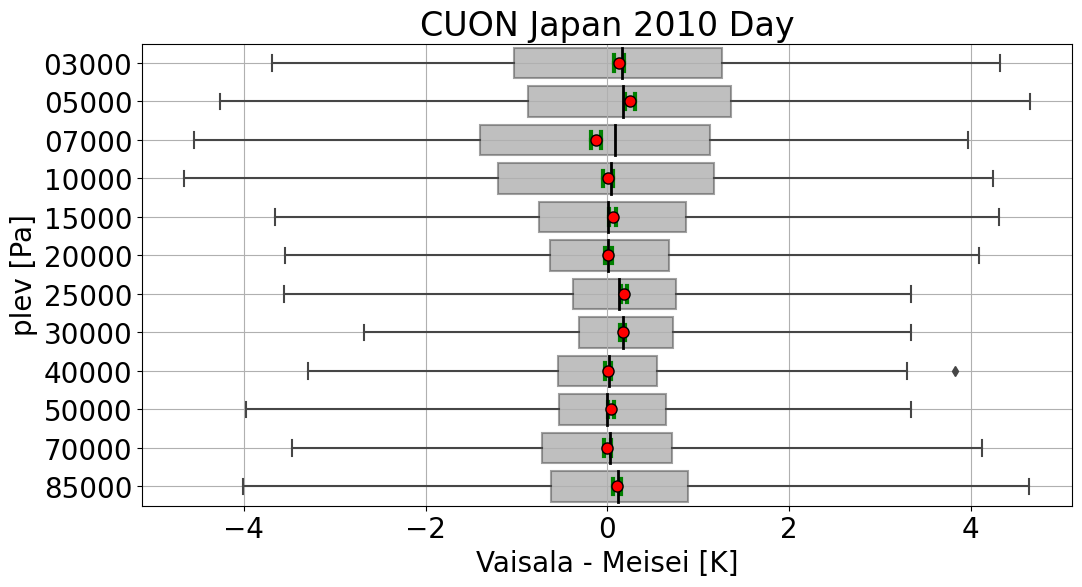

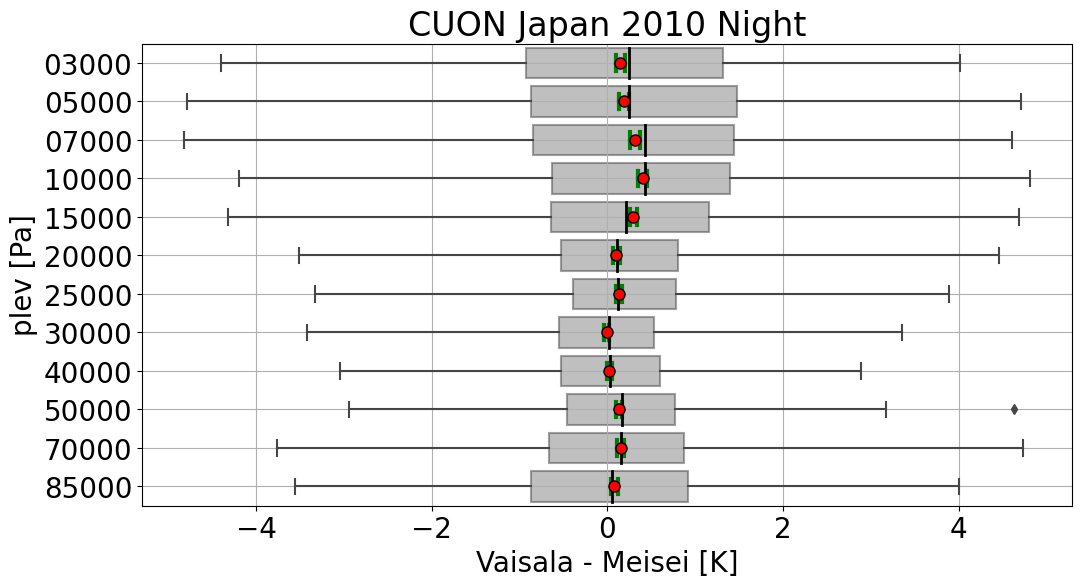

In [17]:
rq = {
    "statid": "47646",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl.to_dataframe()
df_compare.obs_minus_bg = df_compare.obs_minus_bg + df_compare.bias_estimate
print(df_compare.sonde_type.drop_duplicates())

rq = {
    "statid": "47678",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
df_tateno.obs_minus_bg = df_tateno.obs_minus_bg + df_tateno.bias_estimate
print(df_tateno.sonde_type.drop_duplicates())

out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    # print(i.date())
    meis_time = df_tateno[df_tateno.time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].time.iloc[0]
        dh = float((i - mt) / np.timedelta64(1, "h"))
        if np.logical_and(dh < 1, dh > -1):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_tateno[df_tateno.report_id == j]
            v_data = df_compare[df_compare.time == i]
            for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: # range(5000, 90000, 5000):
                diffs.append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                    - m_data[m_data.plev == find_nearest(m_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                )
                out["time"].append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
                )
                out["Difference"].append(diffs[-1])
                out["plev"].append(str(plev))

for tm in ["Day", "Night"]:
    df_in = pd.DataFrame.from_dict(out)
    if tm == "Day":
        df_in = df_in[np.logical_and(df_in.time.dt.hour > 6, df_in.time.dt.hour <= 18)]
    else:
        df_in = df_in[np.logical_or(df_in.time.dt.hour <= 6, df_in.time.dt.hour > 18)]
    df_in.plev = df_in.plev.str.zfill(5)
    df_in = df_in.sort_values(by="plev")

    for i in zip(
        [
            "Difference",
        ],
        ["grey"],
    ):
        q3, q1 = np.percentile(df_in[i[0]].dropna(), [75, 25])
        iqr = q3 - q1
        df_in[i[0]] = df_in[i[0]][
            np.logical_and(df_in[i[0]] < 3 * iqr, df_in[i[0]] > -3 * iqr)
        ]
        ax = seaborn.boxplot(
            data=df_in,
            x=i[0],
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=True,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": i[1], "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
        kwargs = {'alpha':0}
        ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, n_boot=len(df_in[i[0]]), errorbar=('sd',float(2/np.sqrt(len(df_in[i[0]])))), errwidth=3, errcolor='green', **kwargs)
        # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
        ax.set_title('CUON Japan 2010 '+ tm)
        ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
        plt.grid()
        plt.show()
        plt.close()

## Intercomparison 2010

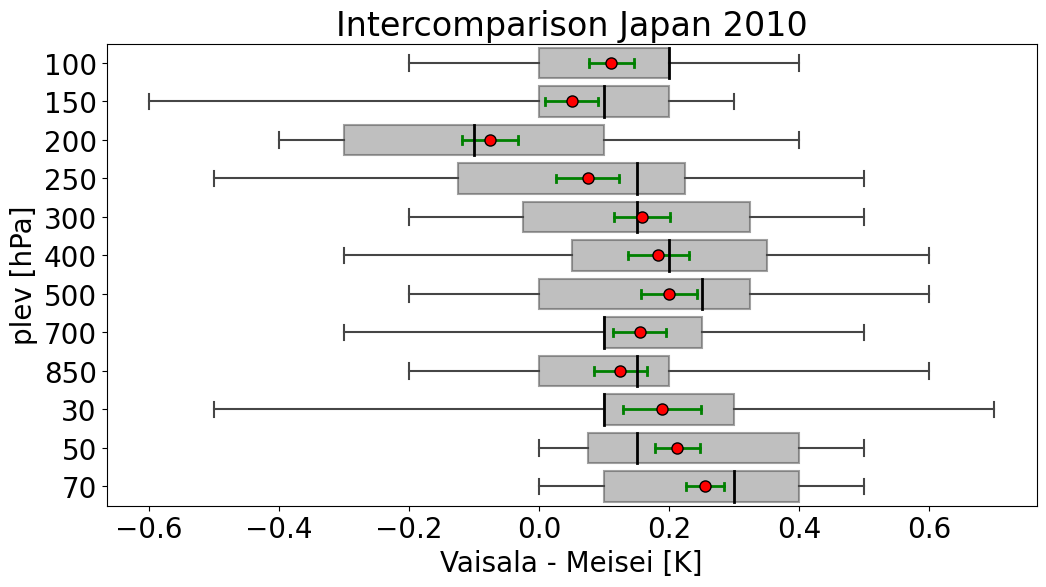

In [18]:
i = labels[2]
label = i[2:].split(".")[0]
data_cleaned[label] = np.array(data_cleaned[label])
plevs[label] = np.array(plevs[label])
q3, q1 = np.percentile(data_cleaned[label], [75 ,25])
iqr = q3 - q1
plevs[label] = plevs[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]
data_cleaned[label] = data_cleaned[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]


ax = seaborn.boxplot(
    x=data_cleaned[label],
    y=plevs[label],
    notch=False,
    showcaps=True,
    showfliers=True,
    dodge=False,
    boxprops={"facecolor": "grey", "alpha": 0.5},
    medianprops={"color": "black", "linewidth": 2},
    meanprops={
        "marker": "o",
        "markerfacecolor": "red",
        "markeredgecolor": "black",
        "markersize": "8",
    },
    showmeans =  True, 
    whis=np.inf,
    # whis=1.5,
).set(xlabel='Vaisala - ' + label + ' [K]', ylabel="plev [hPa]")
kwargs = {'alpha':0}
ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('sd',float(2/np.sqrt(len(data_cleaned[label])))), errwidth=2, errcolor='green', **kwargs)
ax.set_title('Intercomparison Japan 2010')
# ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('ci'), errwidth=3, errcolor='blue', **kwargs)
plt.show()
plt.close()

## 2008

0    J9H 
Name: sonde_type, dtype: object
0    VN8 
Name: sonde_type, dtype: object


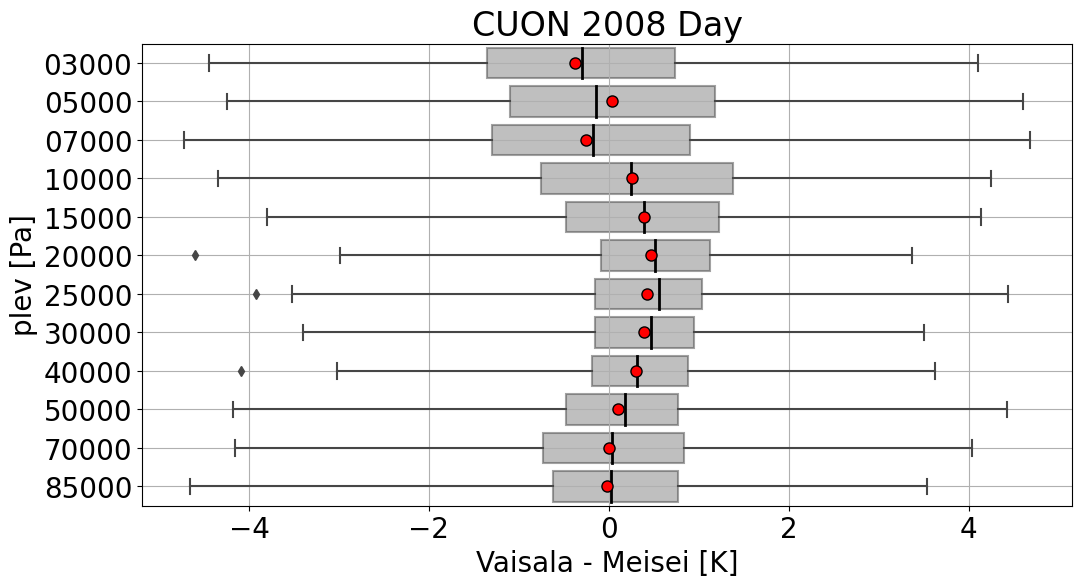

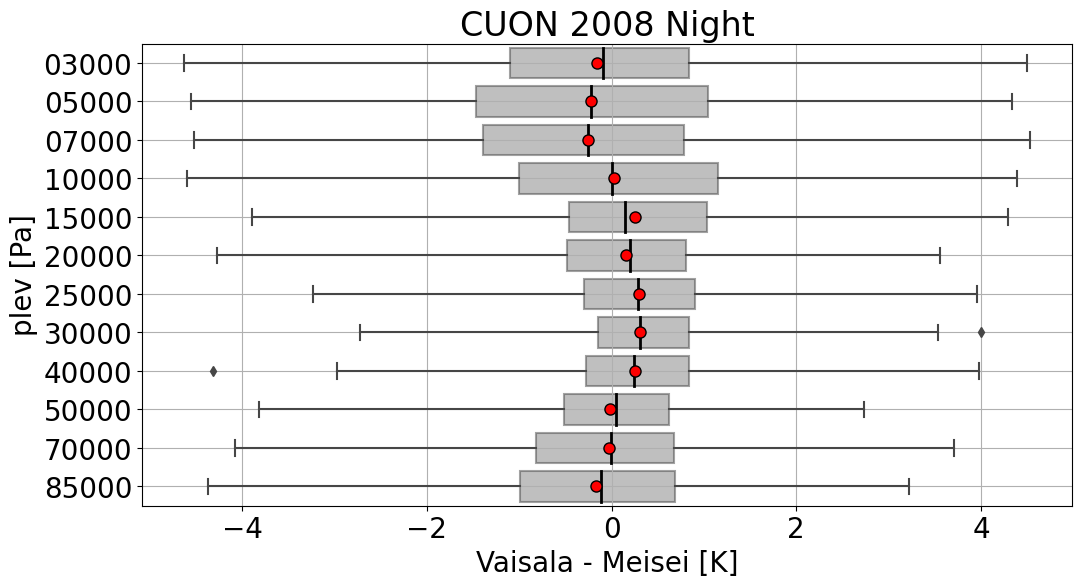

In [19]:
rq = {
    "statid": "47646",
    "date": ["20080101-20081231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl.to_dataframe()
df_compare.obs_minus_bg = df_compare.obs_minus_bg + df_compare.bias_estimate
print(df_compare.sonde_type.drop_duplicates())




rq = {
    "statid": "47678",
    "date": ["20080101-20081231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg", "bias_estimate"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
df_tateno.obs_minus_bg = df_tateno.obs_minus_bg + df_tateno.bias_estimate
print(df_tateno.sonde_type.drop_duplicates())

out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    # print(i.date())
    meis_time = df_tateno[df_tateno.time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].time.iloc[0]
        dh = float((i - mt) / np.timedelta64(1, "h"))
        if np.logical_and(dh < 1, dh > -1):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_tateno[df_tateno.report_id == j]
            v_data = df_compare[df_compare.time == i]
            for plev in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]: #range(5000, 90000, 5000):
                diffs.append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                    - m_data[m_data.plev == find_nearest(m_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                )
                out["time"].append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
                )
                out["Difference"].append(diffs[-1])
                out["plev"].append(str(plev))

for tm in ["Day", "Night"]:
    df_in = pd.DataFrame.from_dict(out)
    if tm == "Day":
        df_in = df_in[np.logical_and(df_in.time.dt.hour > 6, df_in.time.dt.hour <= 18)]
    else:
        df_in = df_in[np.logical_or(df_in.time.dt.hour <= 6, df_in.time.dt.hour > 18)]
    df_in.plev = df_in.plev.str.zfill(5)
    df_in = df_in.sort_values(by="plev")

    for i in zip(
        [
            "Difference",
        ],
        ["grey"],
    ):
        q3, q1 = np.percentile(df_in[i[0]].dropna(), [75, 25])
        iqr = q3 - q1
        df_in[i[0]] = df_in[i[0]][
            np.logical_and(df_in[i[0]] < 3 * iqr, df_in[i[0]] > -3 * iqr)
        ]
        ax = seaborn.boxplot(
            data=df_in,
            x=i[0],
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=True,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": i[1], "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
        kwargs = {'alpha':0}
        # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
        ax.set_title('CUON 2008 '+ tm)
        ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
        plt.grid()
        plt.show()
        plt.close()

## South Korea

47261:  34.5541: 126.5694:  14:V9U:200101000000:+<:Haenam Reference Site, South Korea
47102:  37.9675: 124.6303: 162:V9-:200009281200:*+:Baengyeong Do, South Korea
47169:  34.68: 125.45:  83:VNg:200804010600:*+:Heuksan Do, South Korea 

In [20]:
for i in [47261, 47102, 47169]:
    try:
        rq = {
            "statid": str(i),

            "date": ["20100101-20101231"],
            "variable": ["air_temperature"],
            "format": "nc",
            "optional": ['sonde_type',],
        }
        dl = eua.vm_request_wrapper(rq, overwrite=True)
        df_compare = dl.to_dataframe()
        print(i)
        display(df_compare[:10])
    except:
        print(i, 'no data')

47261 no data
47102


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,37.970001,124.629997,0,3520.0,100000000014674,V9-,0-20000-0-47102,220.899994,2010-01-01
1,37.970001,124.629997,0,3580.0,100000000014674,V9-,0-20000-0-47102,221.100006,2010-01-01
2,37.970001,124.629997,0,3860.0,100000000014674,V9-,0-20000-0-47102,216.300003,2010-01-01
3,37.970001,124.629997,0,4030.0,100000000014674,V9-,0-20000-0-47102,217.899994,2010-01-01
4,37.970001,124.629997,0,4080.0,100000000014674,V9-,0-20000-0-47102,214.500000,2010-01-01
5,37.970001,124.629997,0,4300.0,100000000014674,V9-,0-20000-0-47102,214.899994,2010-01-01
6,37.970001,124.629997,0,5000.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01
7,37.970001,124.629997,0,5010.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01
8,37.970001,124.629997,0,5230.0,100000000014674,V9-,0-20000-0-47102,214.500000,2010-01-01
9,37.970001,124.629997,0,6200.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01


47169


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,34.68,125.449997,0,820.0,100000000004835,VNg,0-20000-0-47169,228.100006,2010-01-01
1,34.68,125.449997,0,1000.0,100000000004835,VNg,0-20000-0-47169,226.300003,2010-01-01
2,34.68,125.449997,0,1400.0,100000000004835,VNg,0-20000-0-47169,219.699997,2010-01-01
3,34.68,125.449997,0,1750.0,100000000004835,VNg,0-20000-0-47169,223.699997,2010-01-01
4,34.68,125.449997,0,2000.0,100000000004835,VNg,0-20000-0-47169,220.500000,2010-01-01
5,34.68,125.449997,0,2420.0,100000000004835,VNg,0-20000-0-47169,218.100006,2010-01-01
6,34.68,125.449997,0,3000.0,100000000004835,VNg,0-20000-0-47169,218.500000,2010-01-01
7,34.68,125.449997,0,3050.0,100000000004835,VNg,0-20000-0-47169,217.899994,2010-01-01
8,34.68,125.449997,0,3350.0,100000000004835,VNg,0-20000-0-47169,220.300003,2010-01-01
9,34.68,125.449997,0,3630.0,100000000004835,VNg,0-20000-0-47169,214.500000,2010-01-01


## Korea stations
### only contain Vaisala or VIZ sondes

In [21]:
rq = {
    "country": 'KOR',

    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ['sonde_type',],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
for i in dl:
    display(dl[i].to_dataframe()[:10])


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,38.25,128.570007,0,8130.0,100000000012621,VNg,0-20000-0-47090,219.500000,2010-01-01
1,38.25,128.570007,0,10000.0,100000000012621,VNg,0-20000-0-47090,215.899994,2010-01-01
2,38.25,128.570007,0,15000.0,100000000012621,VNg,0-20000-0-47090,220.699997,2010-01-01
3,38.25,128.570007,0,16700.0,100000000012621,VNg,0-20000-0-47090,223.500000,2010-01-01
4,38.25,128.570007,0,20000.0,100000000012621,VNg,0-20000-0-47090,223.100006,2010-01-01
5,38.25,128.570007,0,24700.0,100000000012621,VNg,0-20000-0-47090,225.300003,2010-01-01
6,38.25,128.570007,0,25000.0,100000000012621,VNg,0-20000-0-47090,224.300003,2010-01-01
7,38.25,128.570007,0,26300.0,100000000012621,VNg,0-20000-0-47090,219.500000,2010-01-01
8,38.25,128.570007,0,28900.0,100000000012621,VNg,0-20000-0-47090,220.699997,2010-01-01
9,38.25,128.570007,0,30000.0,100000000012621,VNg,0-20000-0-47090,221.699997,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,37.970001,124.629997,0,3520.0,100000000014674,V9-,0-20000-0-47102,220.899994,2010-01-01
1,37.970001,124.629997,0,3580.0,100000000014674,V9-,0-20000-0-47102,221.100006,2010-01-01
2,37.970001,124.629997,0,3860.0,100000000014674,V9-,0-20000-0-47102,216.300003,2010-01-01
3,37.970001,124.629997,0,4030.0,100000000014674,V9-,0-20000-0-47102,217.899994,2010-01-01
4,37.970001,124.629997,0,4080.0,100000000014674,V9-,0-20000-0-47102,214.500000,2010-01-01
5,37.970001,124.629997,0,4300.0,100000000014674,V9-,0-20000-0-47102,214.899994,2010-01-01
6,37.970001,124.629997,0,5000.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01
7,37.970001,124.629997,0,5010.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01
8,37.970001,124.629997,0,5230.0,100000000014674,V9-,0-20000-0-47102,214.500000,2010-01-01
9,37.970001,124.629997,0,6200.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,37.099998,127.029999,0,650.0,100000000075759,???,0-20000-0-47122,234.500000,2010-01-01
1,37.099998,127.029999,0,730.0,100000000075759,???,0-20000-0-47122,233.300003,2010-01-01
2,37.099998,127.029999,0,1000.0,100000000075759,???,0-20000-0-47122,229.100006,2010-01-01
3,37.099998,127.029999,0,1390.0,100000000075759,???,0-20000-0-47122,224.300003,2010-01-01
4,37.099998,127.029999,0,1610.0,100000000075759,???,0-20000-0-47122,226.500000,2010-01-01
5,37.099998,127.029999,0,1690.0,100000000075759,???,0-20000-0-47122,223.899994,2010-01-01
6,37.099998,127.029999,0,2000.0,100000000075759,???,0-20000-0-47122,225.100006,2010-01-01
7,37.099998,127.029999,0,2010.0,100000000075759,???,0-20000-0-47122,225.500000,2010-01-01
8,37.099998,127.029999,0,2170.0,100000000075759,???,0-20000-0-47122,222.500000,2010-01-01
9,37.099998,127.029999,0,3000.0,100000000075759,???,0-20000-0-47122,222.300003,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,36.029999,129.380005,0,640.0,100000000031856,C9,0-20000-0-47138,229.300003,2010-01-01
1,36.029999,129.380005,0,1000.0,100000000031856,C9,0-20000-0-47138,225.500000,2010-01-01
2,36.029999,129.380005,0,1490.0,100000000031856,C9,0-20000-0-47138,221.899994,2010-01-01
3,36.029999,129.380005,0,1580.0,100000000031856,C9,0-20000-0-47138,222.699997,2010-01-01
4,36.029999,129.380005,0,1710.0,100000000031856,C9,0-20000-0-47138,219.699997,2010-01-01
5,36.029999,129.380005,0,1970.0,100000000031856,C9,0-20000-0-47138,221.500000,2010-01-01
6,36.029999,129.380005,0,2000.0,100000000031856,C9,0-20000-0-47138,221.100006,2010-01-01
7,36.029999,129.380005,0,2200.0,100000000031856,C9,0-20000-0-47138,217.500000,2010-01-01
8,36.029999,129.380005,0,2430.0,100000000031856,C9,0-20000-0-47138,219.699997,2010-01-01
9,36.029999,129.380005,0,2620.0,100000000031856,C9,0-20000-0-47138,216.699997,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,35.119999,126.82,0,2360.0,100000000035165,Z4a,0-20000-0-47158,220.899994,2010-01-01
1,35.119999,126.82,0,3000.0,100000000035165,Z4a,0-20000-0-47158,222.100006,2010-01-01
2,35.119999,126.82,0,3140.0,100000000035165,Z4a,0-20000-0-47158,221.899994,2010-01-01
3,35.119999,126.82,0,4150.0,100000000035165,Z4a,0-20000-0-47158,209.100006,2010-01-01
4,35.119999,126.82,0,4930.0,100000000035165,Z4a,0-20000-0-47158,215.300003,2010-01-01
5,35.119999,126.82,0,5000.0,100000000035165,Z4a,0-20000-0-47158,215.300003,2010-01-01
6,35.119999,126.82,0,6960.0,100000000035165,Z4a,0-20000-0-47158,214.899994,2010-01-01
7,35.119999,126.82,0,7000.0,100000000035165,Z4a,0-20000-0-47158,214.699997,2010-01-01
8,35.119999,126.82,0,9920.0,100000000035165,Z4a,0-20000-0-47158,209.899994,2010-01-01
9,35.119999,126.82,0,10000.0,100000000035165,Z4a,0-20000-0-47158,209.899994,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,34.68,125.449997,0,820.0,100000000004835,VNg,0-20000-0-47169,228.100006,2010-01-01
1,34.68,125.449997,0,1000.0,100000000004835,VNg,0-20000-0-47169,226.300003,2010-01-01
2,34.68,125.449997,0,1400.0,100000000004835,VNg,0-20000-0-47169,219.699997,2010-01-01
3,34.68,125.449997,0,1750.0,100000000004835,VNg,0-20000-0-47169,223.699997,2010-01-01
4,34.68,125.449997,0,2000.0,100000000004835,VNg,0-20000-0-47169,220.500000,2010-01-01
5,34.68,125.449997,0,2420.0,100000000004835,VNg,0-20000-0-47169,218.100006,2010-01-01
6,34.68,125.449997,0,3000.0,100000000004835,VNg,0-20000-0-47169,218.500000,2010-01-01
7,34.68,125.449997,0,3050.0,100000000004835,VNg,0-20000-0-47169,217.899994,2010-01-01
8,34.68,125.449997,0,3350.0,100000000004835,VNg,0-20000-0-47169,220.300003,2010-01-01
9,34.68,125.449997,0,3630.0,100000000004835,VNg,0-20000-0-47169,214.500000,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,33.279999,126.169998,0,790.0,100000000043569,C9,0-20000-0-47185,227.300003,2010-01-01
1,33.279999,126.169998,0,1000.0,100000000043569,C9,0-20000-0-47185,225.500000,2010-01-01
2,33.279999,126.169998,0,1350.0,100000000043569,C9,0-20000-0-47185,221.500000,2010-01-01
3,33.279999,126.169998,0,1620.0,100000000043569,C9,0-20000-0-47185,222.699997,2010-01-01
4,33.279999,126.169998,0,2000.0,100000000043569,C9,0-20000-0-47185,221.300003,2010-01-01
5,33.279999,126.169998,0,2120.0,100000000043569,C9,0-20000-0-47185,221.500000,2010-01-01
6,33.279999,126.169998,0,2270.0,100000000043569,C9,0-20000-0-47185,216.899994,2010-01-01
7,33.279999,126.169998,0,2500.0,100000000043569,C9,0-20000-0-47185,216.100006,2010-01-01
8,33.279999,126.169998,0,2830.0,100000000043569,C9,0-20000-0-47185,220.300003,2010-01-01
9,33.279999,126.169998,0,3000.0,100000000043569,C9,0-20000-0-47185,218.100006,2010-01-01
